# Overview
I'd will use unsupervised learning methods and NLP techniques, leverage Spark to perform some analysis to understand why some [Mediun Blog Posts](https://medium.com/) are more popular than others. In fact, there are probably many factors that can contribute to why a blog post is more popular than others. For example, a blog post with a trendy topic, digestible and meaningful contents, a thesis that echos with majority of readers, ..., is probably a popular blog post. However, I will not explore every possible factor that moves the lever. I'd like to narrow down my research scope and explore a specific area, which is the "topic". I'd like to find out answers to two research questions:
1. What "latent topics" do blog writers like to write about? In other words, what is the current trend of 'latent topics' in Midium blog posts' contents
2. What "latent topics" are well-accepted and echo with majority of Medium readers?
3. (Optional) Should blog post writers produce more blogs that cater readers' appetite? 

First of all, we need to define a blog post's "popularity" metric. I will use number of claps as the metric to indicate the level of "popularity" of a blog post.

To understand what are the 'latent topics', we need to use [latent dirichlet allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation)


## Data Sources
There is not a single data science project without data. So I use [scrapy](https://scrapy.org/) to crawl pages on [Mediun Blog Posts](https://medium.com/), and scrap blog title, author, content, claps, and other information, then save them as raw data for research. Source code can be found on [Github](https://github.com/KevinLiao159/MediumBlog/tree/master/src). Due to my limited resources, I only sub-sample a few highlevel topics (data science, blockchain, artificial intelligence, startup, web development, software development) and only query blogs that were posted between 2018/01/01 and 2018/05/01


## Contents
1. Load Data & Basic Data Cleaning 
2. Basic Exploratory Data Analysis
    1. numerical proportion of every topic tag
    2. trends of different topic tags
    3. different topic tags vs. claps
3. Natural Language Processing
    1. preprocess / clean text, tokenization, lemmetization/stemming
    2. TF-IDF vectorization
    3. K-means clustering
    4. LDA (Latent Dirichlet allocation)
    5. validate models by visual displays with dimension reduction (PCA/T-SNE)
4. Analysis on Blog Post Popularity vs. Latent Topics
5. Analysis on Trends in Different Latent Topics
6. Conclusion

In [317]:
import findspark
findspark.init() 
# spark entry point
from pyspark import SparkContext
# dataframe / SQL entry point# datafr 
from pyspark.sql import SQLContext, SparkSession, DataFrame
# spark dataframe utils
from pyspark.sql.functions import (UserDefinedFunction,
                                   explode,
                                   weekofyear,
                                   monotonically_increasing_id,
                                   desc)
from pyspark.sql.types import (StringType,
                               IntegerType,
                               TimestampType,
                               ArrayType,
                               FloatType)
# spark ML
from pyspark.ml import Pipeline
from pyspark.ml.feature import (RegexTokenizer,
                                StopWordsRemover,
                                CountVectorizer,
                                IDF)
from pyspark.ml.clustering import KMeans, LDA
# spark ML lib
from pyspark.mllib.linalg import DenseVector

# data science import
import nltk
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# other import
import os
import time
import itertools
from unicodedata import normalize
from functools import reduce

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from __future__ import division # for Python 2.x

import warnings
warnings.filterwarnings('ignore')

In [3]:
# spark config
sc = SparkContext(master=os.environ['SPARK_URL'])
sql_sc = SQLContext(sc)
spark = SparkSession(sc)

In [4]:
# path config
data_path = os.path.join(os.environ['DATA_PATH'], 'medium')

# get json lines files
path_files = [os.path.join(data_path, f_name) for f_name in os.listdir(data_path) if f_name.endswith('.jl')]

## Load Data & Basic Data Cleaning 
I use spark sql session to read json lines directly.
1. read data in Spark engine
2. normalize text
3. convert data type to proper type
4. filter date range

In [5]:
def preprocess(data):
    """
    preprcess raw data
    
    input: spark dataframe
    output: spark dataframe with proper dtypes and clean/normalized unicode string
    """
    # create a user defined functon for apply method in spark dataframe
    normalizer = UserDefinedFunction(lambda x: normalize('NFKD', x).replace(';', ' '), StringType())
    # normalization and date filter
    data = data.select(
        data.publish_time.cast(TimestampType()),
        normalizer("title").alias("title"),
        normalizer("contents").alias("contents"),
        data.claps.cast(IntegerType()),
        data.tags.cast(ArrayType(StringType())),
    )
    return data.filter(data.publish_time > '2018-01-01').filter(data.publish_time < '2018-04-30')


def unionAll(*dfs):
    """
    union all tables into one table vertically
    """
    return reduce(DataFrame.unionAll, dfs)

In [6]:
# init list of spark dataframes
dfs = []
for path in path_files:
    # read json data into spark driver
    data = spark.read.json(path)
    # preprocess
    data = preprocess(data)
    # append to list
    dfs.append(data)
    
# union all
df = unionAll(*dfs).drop_duplicates(subset=['title'])
# add id column for easy join later
df = df.select("*").withColumn("id", monotonically_increasing_id())

In [7]:
df.show(5)

+-------------------+--------------------+--------------------+-----+--------------------+---+
|       publish_time|               title|            contents|claps|                tags| id|
+-------------------+--------------------+--------------------+-----+--------------------+---+
|2018-01-08 00:00:00|12 Question Co-Fo...|When building a b...|   17|[Startup, Retrosp...|  0|
|2018-03-08 00:00:00|12 Startups in 12...|Few days ago duri...|    1|[Startup, Product...|  1|
|2018-03-08 00:00:00|17 Tips & Tricks ...|This is the third...|  202|[Freelancing, Sof...|  2|
|2018-03-27 00:00:00|3 Great Ways in W...|“If you run a bus...|    0|[Web Development,...|  3|
|2018-03-17 00:00:00|4 Things To Keep ...|As you know web d...|    0|[Web Development,...|  4|
+-------------------+--------------------+--------------------+-----+--------------------+---+
only showing top 5 rows



## Basic Exploratory Data Analysis
1. numerical proportion of every topic tag
2. trends of different topic tags
3. different topic tags vs. claps

#### 1. numerical proportion of every topic tag

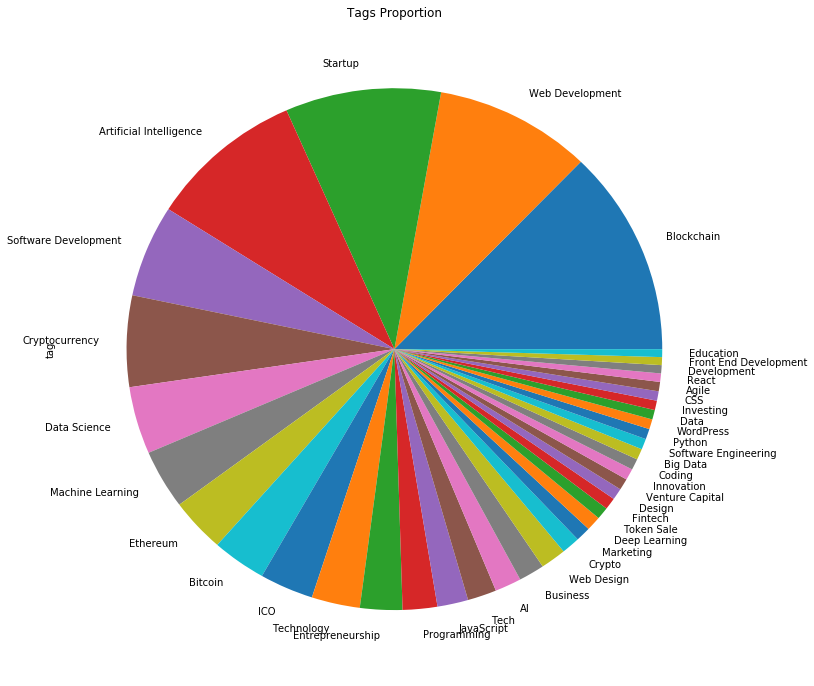

In [8]:
# collect data and convert it to pandas
pddf = df.select('tags').toPandas()
# flatten a list
tags = list(itertools.chain(*pddf.tags.values))
# visualization
pd.DataFrame(tags, columns=['tag'])\
    .groupby('tag')['tag']\
    .count()\
    .sort_values(ascending=False)[:40]\
    .plot(
        kind='pie',
        figsize=(12, 12),
        fontsize=10,
        title='Tags Proportion',
)

Pie chart shows numerical proportion of each topic tag. We can see that:
1. Blog writter were crazy about Blockchain between 2008-01-01 and 2008-05-01
2. The order of top 8 tags: Blockchain, Wed Development, Artificial Intelligence, Startup, Software Development, Crytocurrency, Data Science, Machine Learning

#### 2. trends of different topic tags

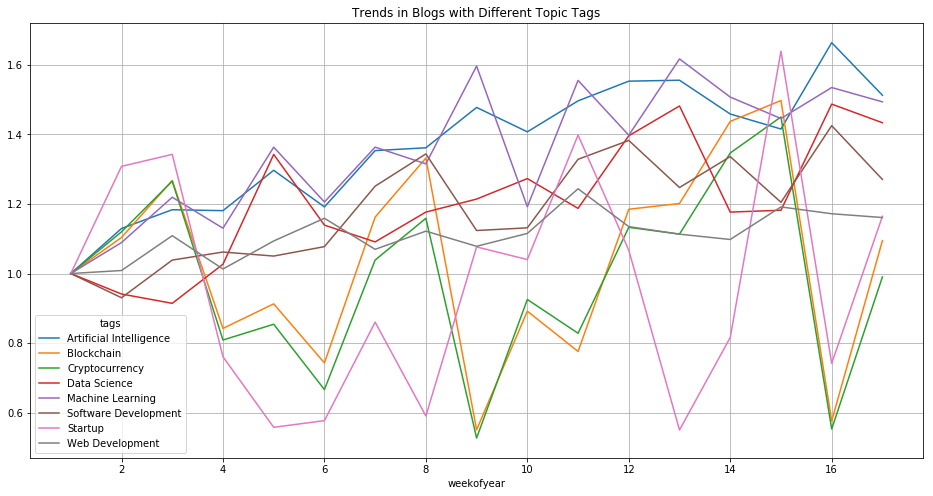

In [9]:
# get top 8 tags
top_tags = pd.DataFrame(tags, columns=['tag']) \
    .groupby('tag')['tag'] \
    .count() \
    .sort_values(ascending=False)[:8] \
    .index \
    .tolist()
# explode the tags
df_explode = df.select('publish_time', explode('tags').alias('tags'))
# get weekly blog counts
pddf = df_explode.filter(df_explode.tags.isin(top_tags)) \
    .groupby(weekofyear(df_explode.publish_time).alias("weekofyear"), df_explode.tags) \
    .count() \
    .toPandas() \
    .sort_values(['weekofyear', 'tags'], ascending=True)

# normalize data
pddf_norm = pddf.pivot(index='weekofyear', columns='tags', values='count').apply(lambda x: x / x.iloc[0])
# plot
pddf_norm.plot(
    figsize=(16, 8),
    title='Trends in Blogs with Different Topic Tags',
    grid=True)

Line plot shows trends of different topics, we can see that:
1. Artificial Intelligence, Machine Learning, Data Science show a consistent and strong upward trends
2. On the other side, Blockchain, Cryptocurrency, and Startup suffers a inconsistent flat trend with high volatility
3. Some topics are highly correlated with each other

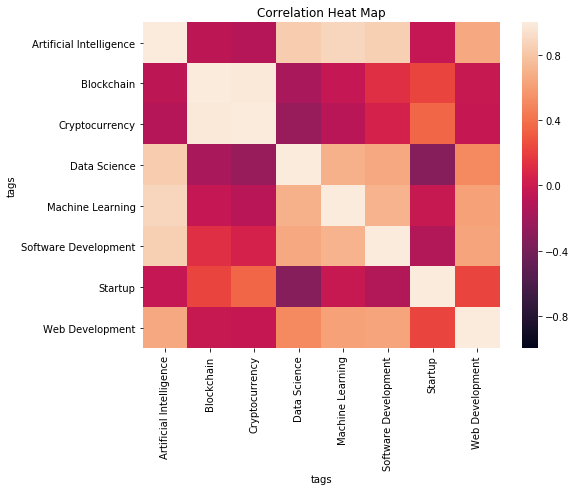

In [10]:
# heat map visual
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Correlation Heat Map')
sns.heatmap(pddf_norm.corr() ,vmin=-1, vmax=1, ax=ax)

Heap map shows correlation of trends in different topics. There are basically two groups of topics.
1. Group 1: AI, Data Science, Machine Learning, Software development, Web Development
2. Group 2: Blockchain, Crytocurrency, Startup

Trends of topics are highly positively correlated within their group. Trends are highly negatively correlated cross different groups

#### 3. different topic tags vs. claps

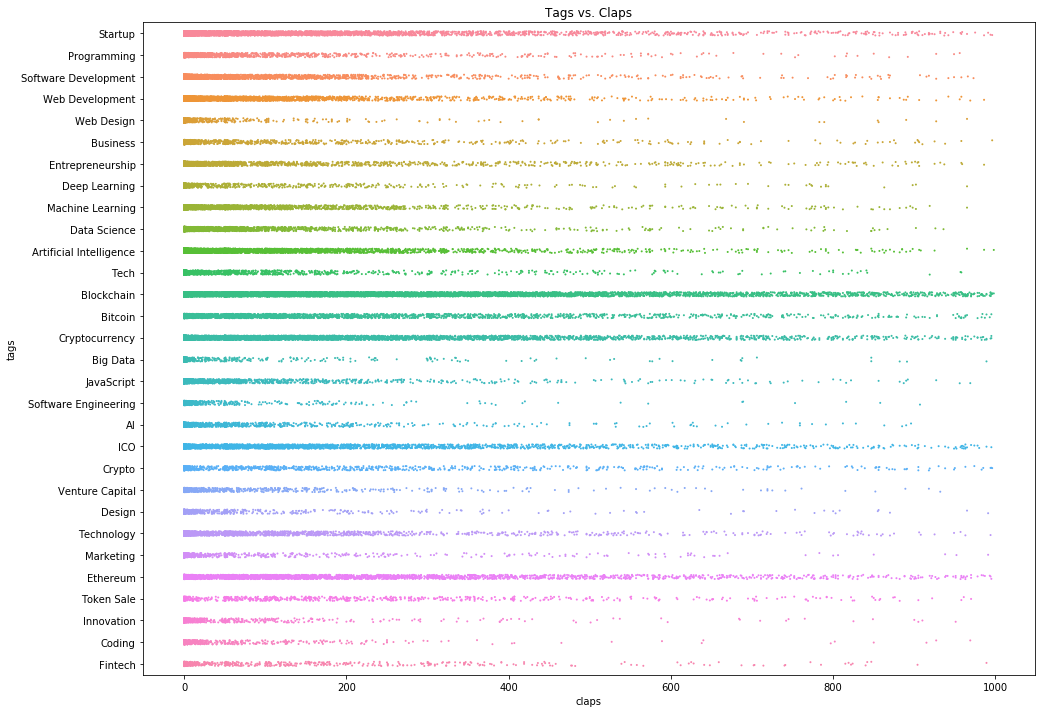

In [11]:
# get top 30 tags
top_tags = pd.DataFrame(tags, columns=['tag']) \
    .groupby('tag')['tag'] \
    .count() \
    .sort_values(ascending=False)[:30] \
    .index \
    .tolist()
# explode the tags
df_explode = df.select('claps', explode('tags').alias('tags'))
# filter
pddf = df_explode \
    .filter(df_explode.tags.isin(top_tags)) \
    .filter(df_explode.claps < 1000) \
    .toPandas()
# plot
f, ax = plt.subplots(figsize=(16, 12))
ax.set_title('Tags vs. Claps', fontsize=12)
sns.stripplot(x='claps', y='tags', data=pddf, ax=ax, jitter=1, marker='.', size=4)

Strip plot shows a rough distribution of claps for each tag. We filter down to top 30 tags based on number of claps and also filter time window between 2018-01-01 and 2018-05-01<br/>
we can see that:
1. Cryto concepts like Blockchain, ICO, Ethereum are very dense from 0 clap to 1000 claps
2. Second hot topic: AI, machine learning, data science
3. Third hot topic: Startup, Entreprenearship
4. The rest are coding, web design, big data, software engineering

## Natural Language Processing Using Spark ML
1. tokenization, stop word removal, Count vectorization, IDF vectorization
2. K-means clustering
3. LDA (Latent Dirichlet allocation) topic modeling
4. validate models by visual displays with dimension reduction (PCA/T-SNE)

<br/>
<br/>
NOTE: we need two different Spark ML pipelines for analysis
1. tokenizer ->  stop word remover -> count vectorizer -> idf vectorizer -> K-means
2. tokenizer ->  stop word remover -> count vectorizer -> LDA

However, we only need two features for two different models
1. feature one: count feature
2. feature two: tf-idf feature

#### 1. tokenization, stop word removal, Count vectorization, IDF vectorization

In [14]:
# Configure ML pipeline for feature extraction
# which consists of three stages: tokenizer, stop word remover, count vectorizer, idf vectorizer
tokenizer = RegexTokenizer(gaps=True, pattern="\\W", inputCol="contents", outputCol="words")
remover = StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol="tokens")
countTF = CountVectorizer(minTF=2, minDF=0.05, maxDF=0.7, vocabSize=1000, inputCol=remover.getOutputCol(), outputCol="tf")
idf = IDF(minDocFreq=20, inputCol=countTF.getOutputCol(), outputCol="idf")

pipeline = Pipeline(stages=[tokenizer, remover, countTF, idf])

# Fit and transform raw contents to features
model = pipeline.fit(df)
df_features = model.transform(df)
# get selected_words
selected_words = model.stages[-2].vocabulary

In [15]:
df_features.select('id', 'title', 'tf', 'idf').show(2)

+---+--------------------+--------------------+--------------------+
| id|               title|                  tf|                 idf|
+---+--------------------+--------------------+--------------------+
|  0|12 Question Co-Fo...|(1000,[2,16,18,56...|(1000,[2,16,18,56...|
|  1|12 Startups in 12...|(1000,[1,3,10,11,...|(1000,[1,3,10,11,...|
+---+--------------------+--------------------+--------------------+
only showing top 2 rows



#### 2. K-means clustering

In [28]:
# # Trains a series of K-means models to pick the optimal k
# seed = 99
# max_k = 150
# skip = 5
# cost = []

# for k in range(2, max_k, skip):
#     t0=time.time()
#     kmeans = KMeans().setK(k).setSeed(seed).setFeaturesCol("idf")
#     model = kmeans.fit(df_features)
#     cost.append(model.computeCost(df_features))
#     print('It took {}'.format(time.time()-t0))
#     print('Done', k, '>>>>>>>>>>>>>')

Text(0,0.5,'cost')

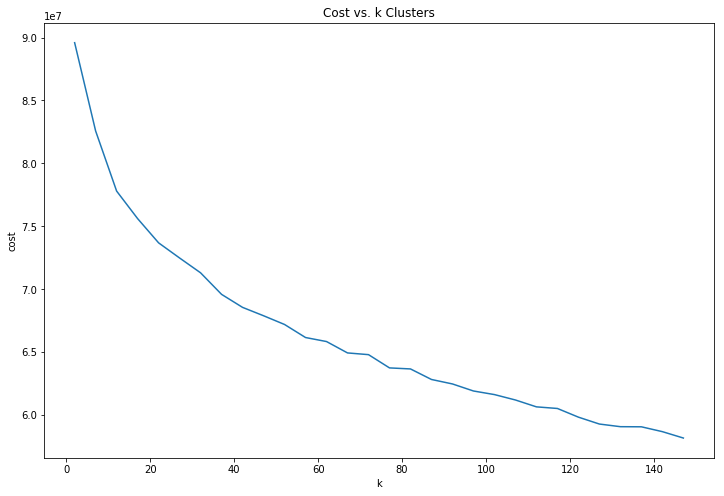

In [14]:
# plot cost vs. k clusters
fig, ax = plt.subplots(1,1, figsize =(12,8))
ax.plot(range(2, max_k, skip), cost)
ax.set_title('Cost vs. k Clusters')
ax.set_xlabel('k')
ax.set_ylabel('cost')

We can see that mean squared error drops sharply from 0 to 60. When k > 60, the curve starts to show a flatter shape. For the sake of easier analysis and visualization. Let's choose 20 clusters

In [231]:
# Trains a k-means model with optimal k
k = 20
seed = 99

# Train
t0 = time.time()
kmeans = KMeans().setK(k).setSeed(seed).setFeaturesCol("idf")
model = kmeans.fit(df_features)
sorted_idx_centroids = np.asarray(model.clusterCenters())
print('It took {:.2f}s to train a model'.format(time.time() - t0))

It took 52.99s to train a model


In [232]:
# Get K-means predictions
df_pred = model.transform(df_features).cache()
df_pred.select('id', 'title', 'prediction').show(3)

+---+--------------------+----------+
| id|               title|prediction|
+---+--------------------+----------+
|  0|12 Question Co-Fo...|         0|
|  1|12 Startups in 12...|         0|
|  2|17 Tips & Tricks ...|        11|
+---+--------------------+----------+
only showing top 3 rows



In [233]:
# Check group size for each cluster
df_pred.groupby('prediction').count().sort(desc("count")).show(30)

+----------+-----+
|prediction|count|
+----------+-----+
|         0|26341|
|        11| 6824|
|        12| 1915|
|         7| 1625|
|        19| 1593|
|        13| 1531|
|         6| 1099|
|         1|  992|
|         4|  841|
|        17|  265|
|        14|  141|
|        16|   54|
|         3|   14|
|         2|    5|
|         5|    5|
|        15|    3|
|        10|    2|
|        18|    2|
|         8|    1|
|         9|    1|
+----------+-----+



We can see that K-means clustering doesn't cluster different topics very well. It puts 26341 blogs in one cluster, and other clusters like 2, 5, 15, ..., 9 only has less than 5 blogs in its cluster. This is very poor-balanced clustering

#### 3. LDA topic modeling

In [238]:
# Trains a LDA model with number of topic = 30
k = 20
seed = 99

# Train
t0 = time.time()
lda = LDA().setK(k).setSeed(seed).setFeaturesCol("tf")
model = lda.fit(df_features)
print('It took {:.2f}s to train a model'.format(time.time() - t0))

It took 211.15s to train a model


let's define a function a function to extract key words that describe each topic

In [239]:
def get_topic_key_words(model, vocab):
    """
    input: 
        model, fitted LDA model
        vocab, list of words in vocab
    output: topic dataframe with key words
    """
    # define get_words function
    get_words = UserDefinedFunction(lambda x: [vocab[i] for i in x], ArrayType(StringType()))
    return model.describeTopics().select('*', get_words('termIndices').alias("keyWords"))

In [240]:
pd.set_option('max_colwidth', 120)
df_topic = get_topic_key_words(model, selected_words)
df_topic.select('topic', 'keyWords').toPandas()

,topic,keyWords
0,0,"[blockchain, token, tokens, platform, bitcoin, ico, crypto, network, ethereum, market]"
1,1,"[learning, ai, machine, intelligence, data, artificial, human, deep, algorithms, computer]"
2,2,"[000, year, facebook, new, growth, one, 10, 2017, news, 1]"
3,3,"[content, use, page, like, also, function, one, code, html, using]"
4,4,"[network, system, networks, one, energy, learning, training, input, different, model]"
5,5,"[global, financial, company, founder, companies, technology, capital, digital, investment, management]"
6,6,"[com, https, use, file, server, need, using, create, address, run]"
7,7,"[team, product, business, company, people, one, work, time, new, re]"
8,8,"[app, google, apps, mobile, service, user, like, users, use, need]"
9,9,"[software, business, development, time, organization, program, 2018, startup, one, get]"


LDA model is able to classfiy 20 different latent topics within 40K blogs. We can kinda have some basic ideas about some of these latent topic. For example, 
1. Topic one: mainly talks about blockchain, its platforms, networks, and coin markets
2. Topic two: artificial intelligence and deep learning topic <br/>
... <br/>
5. Topic five: is about the finance and investment perspective  <br/>
... <br/>
17. Topic 17: mainly talks about web development
18. Topic 18: talks about how to spend time, work with people, mostly about life and motivation

Let's use fitted LDA model to make inference on Medium Blogs. First we need a helper function to extract the most important topic for each blog

In [241]:
def get_topic(df_prediction):
    """
    input: prediction dataframe
    output: prediction dataframe with topic column
    """
    # define get_words function
    get_topic = UserDefinedFunction(lambda x: int(x.values.argsort()[::-1][0]), IntegerType())
    return df_prediction.select('*', get_topic('topicDistribution').alias("topic"))

In [242]:
# make prediction
df_pred = get_topic(model.transform(df_features)).cache()
df_pred.select('id', 'title', 'topic').show(3)

+---+--------------------+-----+
| id|               title|topic|
+---+--------------------+-----+
|  0|12 Question Co-Fo...|    7|
|  1|12 Startups in 12...|   18|
|  2|17 Tips & Tricks ...|    9|
+---+--------------------+-----+
only showing top 3 rows



In [245]:
# Check group size for each cluster
df_pred.groupby('topic').count().sort(desc("count")) \
    .join(df_topic, 'topic') \
    .select('topic', 'count', 'keyWords') \
    .show()

+-----+-----+--------------------+
|topic|count|            keyWords|
+-----+-----+--------------------+
|    0| 7582|[blockchain, toke...|
|   18| 6100|[time, like, get,...|
|    7| 3771|[team, product, b...|
|   19| 3273|[world, us, peopl...|
|    6| 2384|[com, https, use,...|
|    3| 2366|[content, use, pa...|
|   15| 2284|[ai, technology, ...|
|   17| 2145|[web, development...|
|   16| 1907|[data, model, sci...|
|    1| 1771|[learning, ai, ma...|
|   13| 1734|[code, software, ...|
|    5| 1273|[global, financia...|
|   14| 1051|[1, 0, 2, 3, 4, c...|
|    9|  996|[software, busine...|
|   10|  959|[business, websit...|
|    2|  929|[000, year, faceb...|
|    4|  790|[network, system,...|
|   11|  732|[one, data, cours...|
|   12|  613|[user, users, val...|
|    8|  594|[app, google, app...|
+-----+-----+--------------------+



We can see that LDA provides a much better clustering. The sizes of groups are more evenly distributed. Blockchain is the hottest topic at that time, most blog writers chose blockchain topic to write about in Medium 

#### 4. validate models by visual displays with dimension reduction (PCA/T-SNE)

In [354]:
# let's sample 20% of data for visualization
df_sample = df_pred.select('id', 'idf', 'topic', 'claps').sample(False, 0.2, seed=99).toPandas()
# let's convert sparse idf features back to dense array for PCA / T-SNE
mat_tf_idf = np.vstack(df_sample.idf.map(lambda v: v.toArray()).tolist())

PCA approach

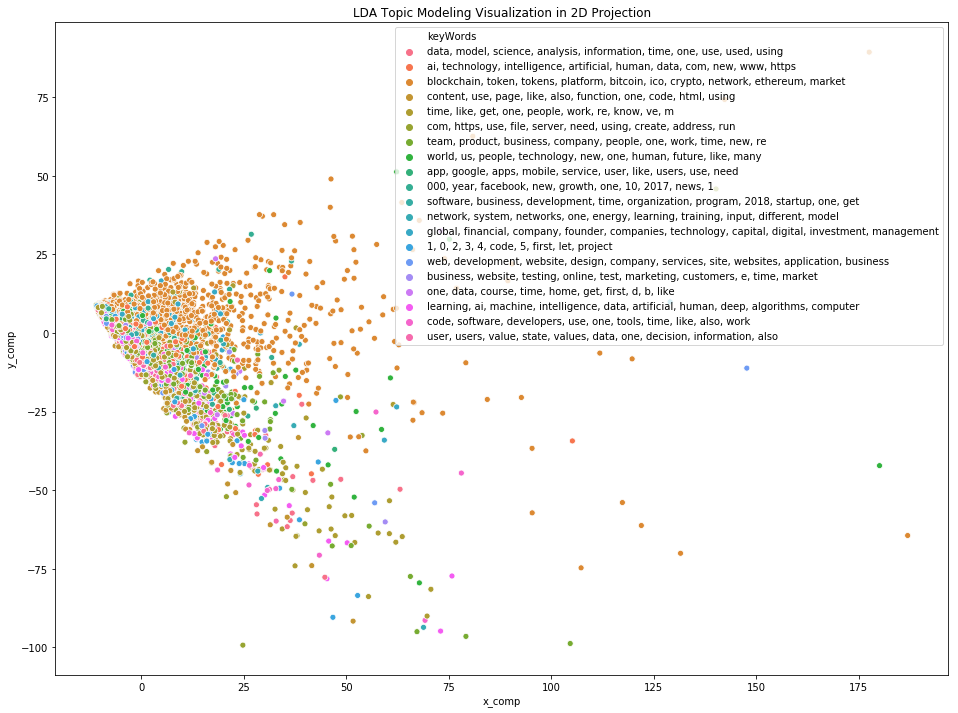

In [344]:
# train PCA
pca = PCA(n_components=2).fit(mat_tf_idf)
# get 2-D representation of our data
X_pca = pca.transform(mat_tf_idf)
# convert to dataframe for visualization
df_pca = pd.DataFrame(X_pca, columns=['x_comp', 'y_comp'])
df_pca['topic'] = df_sample['topic'].copy().values
df_pca['keyWords'] = df_sample['topic'].map(
    df_topic.select('topic', 'keyWords').toPandas().set_index('topic').to_dict()['keyWords']
).apply(lambda x: ', '.join(x))

# plot
fig, ax = plt.subplots(figsize=(16, 12))
ax.set_title('LDA Topic Modeling Visualization in 2D Projection')
sns.scatterplot(
    x="x_comp",
    y="y_comp",
    hue='keyWords',
    data=df_pca.query('-100 < x_comp < 200').query('-100 < y_comp < 100'),
    ax=ax
)

T-SNE approach

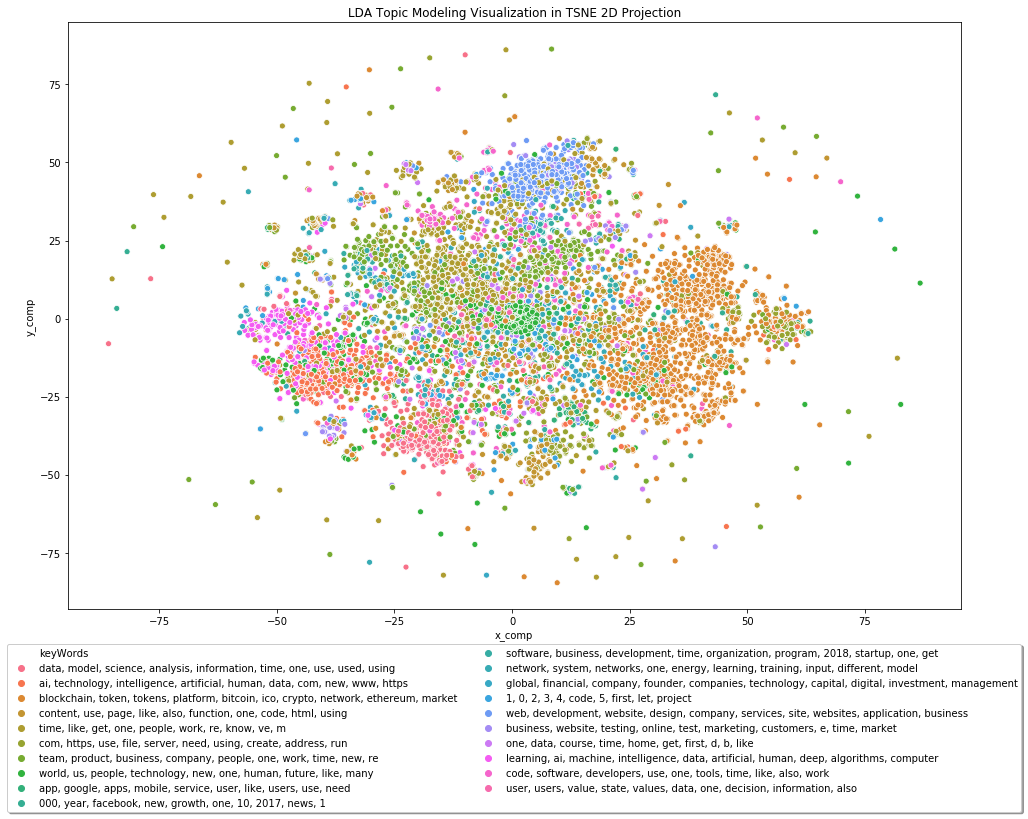

In [352]:
# get 2-D representation of our data
X_tsne_embedded = TSNE(n_components=2, random_state=99).fit_transform(mat_tf_idf)
# convert to dataframe for visualization
df_tsne = pd.DataFrame(X_tsne_embedded, columns=['x_comp', 'y_comp'])
df_tsne['topic'] = df_sample['topic'].copy().values
df_tsne['keyWords'] = df_sample['topic'].map(
    df_topic.select('topic', 'keyWords').toPandas().set_index('topic').to_dict()['keyWords']
).apply(lambda x: ', '.join(x))

# plot
fig, ax = plt.subplots(figsize=(16, 12))
ax.set_title('LDA Topic Modeling Visualization in TSNE 2D Projection')
sns.scatterplot(
    x="x_comp",
    y="y_comp",
    hue='keyWords',
    data=df_tsne,
    ax=ax
)
# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=2)

### Observation
1. We can see that T-SNE plot shows a cleaner clustering representation of data. We can see that the clusters of different topics are more spread out in T-SNE visualization than in PCA projection. Also the distance between clusters are more meaningful in T-SNE presentation than in PCA projection. Cluster in orange about the topic of 'Blockchain' is closer to the cluster in green about the topic of 'software development' than the cluster in purple about the topic of 'Artificial Intelligence'

2. Interestingly, the center of the TSNE plot is the cluster in green, which is about 'software development' and 'Business'. This latent topic shows up in multiple different topics too. It shows up in 'Blockchain', 'Web development', 'Machine Learning', and 'AI'.

3. This is saying the latent topic of 'software' and 'business' is the ubiquitous concept that underpins most of the blogs on Medium

4. Also, one more thing worths to point out is that there are many single dots far away from the center mass. Those blogs probably contain topics that are so different than the majority topics

## 4. Analysis on Blog Post Popularity vs. Latent Topics

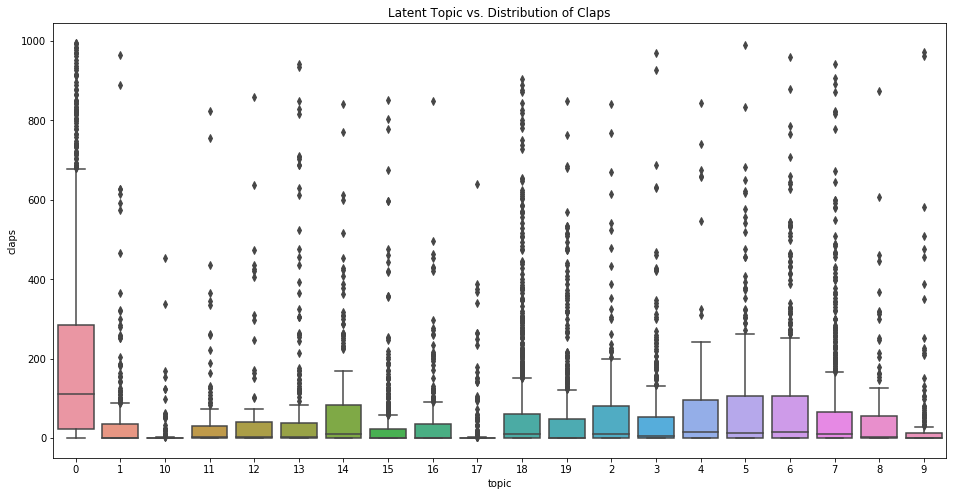

In [376]:
# prep data for visualization
data = df_sample.query('claps < 1000')
data['topic'] = data['topic'].astype('str')
data['claps_mean_by_topic'] = data.groupby('topic')['claps'].transform(lambda x: x.mean())

# plot
f, ax = plt.subplots(figsize=(16, 8))
ax.set_title('Latent Topic vs. Distribution of Claps', fontsize=12)
sns.boxplot(x='topic', y='claps', data=data, ax=ax)

In [398]:
data[['claps']].astype('int') \
    .groupby(data.topic.astype('int')) \
    .mean() \
    .sort_values('claps', ascending=False) \
    .join(df_topic.select('topic', 'keyWords').toPandas().set_index('topic'))

,claps,keyWords
topic,,
0,193.157320,"[blockchain, token, tokens, platform, bitcoin, ico, crypto, network, ethereum, market]"
5,89.681633,"[global, financial, company, founder, companies, technology, capital, digital, investment, management]"
6,88.630045,"[com, https, use, file, server, need, using, create, address, run]"
14,79.000000,"[1, 0, 2, 3, 4, code, 5, first, let, project]"
4,77.293706,"[network, system, networks, one, energy, learning, training, input, different, model]"
2,73.627027,"[000, year, facebook, new, growth, one, 10, 2017, news, 1]"
7,67.509485,"[team, product, business, company, people, one, work, time, new, re]"
18,64.407006,"[time, like, get, one, people, work, re, know, ve, m]"
13,62.987654,"[code, software, developers, use, one, tools, time, like, also, work]"


We can see that Blockchain topic is the most popular topic on Medium from 2018-01-01 to 2018-05-01

## 5. Analysis on Trends in Different Latent Topics
let's hand pick some latent topic for this analysis. I'd like look at
1. Blockchain (topic 0)
2. Finance (topic 5)
3. Life motivation (topic 18)
4. Software and business (topic 9)
5. AI (topic 1)
6. Web development (topic 17)

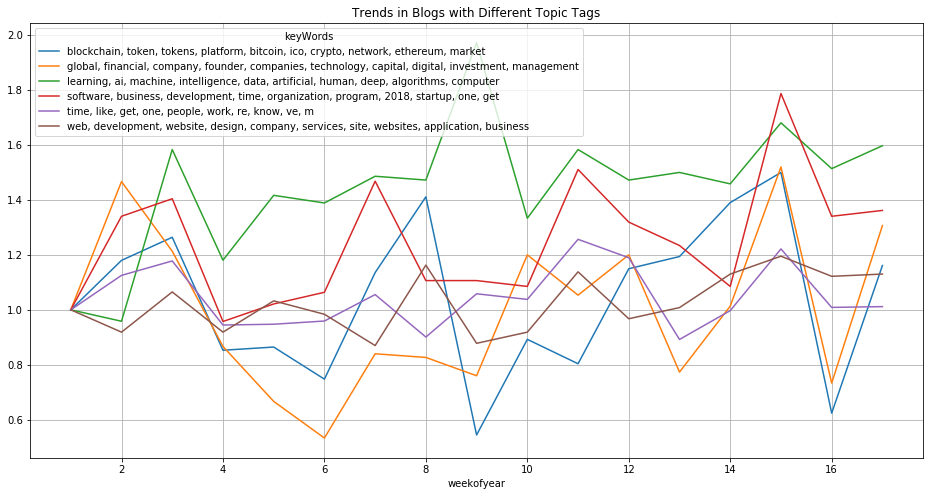

In [429]:
# get weekly blog counts
topic_interests = [0, 1, 5, 9, 17, 18]

pddf = df_pred.filter(df_pred.topic.isin(topic_interests)) \
    .select('publish_time', 'topic') \
    .groupby(weekofyear(df_pred.publish_time).alias("weekofyear"), df_pred.topic) \
    .count() \
    .toPandas() \
    .merge(
        df_topic.select('topic', 'keyWords').toPandas(),
        on='topic',
        how='left') \
    .sort_values(['weekofyear', 'topic'], ascending=True)

# normalize data
pddf['keyWords'] = pddf['keyWords'].apply(lambda x: ', '.join(x))
pddf_norm = pddf.pivot(index='weekofyear', columns='keyWords', values='count').apply(lambda x: x / x.iloc[0])

# plot
pddf_norm.plot(
    figsize=(16, 8),
    title='Trends in Blogs with Different Topic Tags',
    grid=True)

Above plot is normalized for comparison. Every data point is scaled by the number of blog posts of first week.
We can see that:
1. AI/Machine Learning and software/business topics are trending up
2. Blockchain topic flattens and varies a lot from week to week
3. Life motivation topic are steady and remains fairly constant



## 6. Conclusion

Researcher can leverage NLP techniques and machine learning methods to further understand the composition of latent topics behind most of the blog post contents. Research can also identify trends of different topics in Medium blog posts and what topics are popular among Medium readers

1. We found out Blockchain topics are the most popular topic from 2018-01-01 to 2018-05-01. This echos the bitcoin hype during that time. After that, blockchain topic seems to stop growing and quiet down
2. However, AI/Machine Learning and software/business topics are trending up at a steady rate
3. Readers tend to prefer reading high-level concepts that are related to business, startup, investment such as bitcoin markets, global finance, startup,....
4. Readers are less interested in reading low-level implementation of technologies such as web development, testing, data analysis
5. I think Blog post writer as content producer should write about whatever topic is interesting to them, instead of blindly following popular trends